In [11]:
import torch
import torch.functional as F
from transformers import AutoTokenizer, AutoModel,\
    AutoModelForMaskedLM, AutoModelForSequenceClassification, AutoModelForCausalLM
    
%config InlineBackend.figure_format = 'retina'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [18]:
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F

tok = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased").eval()

text = ["AI for sustainability is important and climate matters too."]
inputs = tok(text, return_tensors='pt')
with torch.no_grad():
    out = model(**inputs)
embeds = out.last_hidden_state[0]   # [T, D]
tokens = tok.convert_ids_to_tokens(inputs.input_ids[0])


print(embeds.shape)
for t, e in zip(tokens, embeds):
    print(f"{t:15} {e[:6].tolist()} ... {e[-6:].tolist()}")



torch.Size([12, 768])
[CLS]           [-0.2192813605070114, 0.06082843989133835, -0.15943028032779694, -0.07410778850317001, -0.8064565062522888, -0.29445990920066833] ... [-0.23841002583503723, 0.1589999943971634, -0.429440975189209, -0.6893839240074158, 0.15146473050117493, 0.13880839943885803]
ai              [-0.020448271185159683, 0.2653367221355438, 0.3434016704559326, 0.01981567218899727, 0.9403035640716553, -0.09740622341632843] ... [0.4278835654258728, 0.4959240257740021, 0.036015138030052185, -0.7529479265213013, -0.2872113585472107, -0.03700032830238342]
for             [0.280131995677948, 0.09756920486688614, 0.4826517403125763, 0.459640771150589, -0.009674344211816788, 0.02010003849864006] ... [0.42004698514938354, 0.1284080594778061, -0.28999263048171997, -0.42000478506088257, -0.21347713470458984, -0.25229623913764954]
sustainability  [1.02855384349823, -0.10809800773859024, 0.0003578402101993561, 0.5034545660018921, 1.2729973793029785, -1.2800869941711426] ... [0.859642

In [19]:
def cosine_sim(a, b): return F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()

for i, t in enumerate(tokens):
    sims = [cosine_sim(embeds[i], embeds[j]) for j in range(len(tokens))]
    top = torch.topk(torch.tensor(sims), k=3).indices.tolist()
    print(f"{t:>16} → {[tokens[j] for j in top]}")

           [CLS] → ['[CLS]', 'ai', 'is']
              ai → ['ai', 'for', 'important']
             for → ['for', 'is', 'and']
  sustainability → ['sustainability', 'climate', 'is']
              is → ['is', 'matters', 'important']
       important → ['important', 'matters', 'is']
             and → ['and', 'too', 'is']
         climate → ['climate', 'sustainability', 'matters']
         matters → ['matters', 'important', 'is']
             too → ['too', 'is', 'and']
               . → ['.', '[SEP]', 'is']
           [SEP] → ['[SEP]', 'is', 'too']


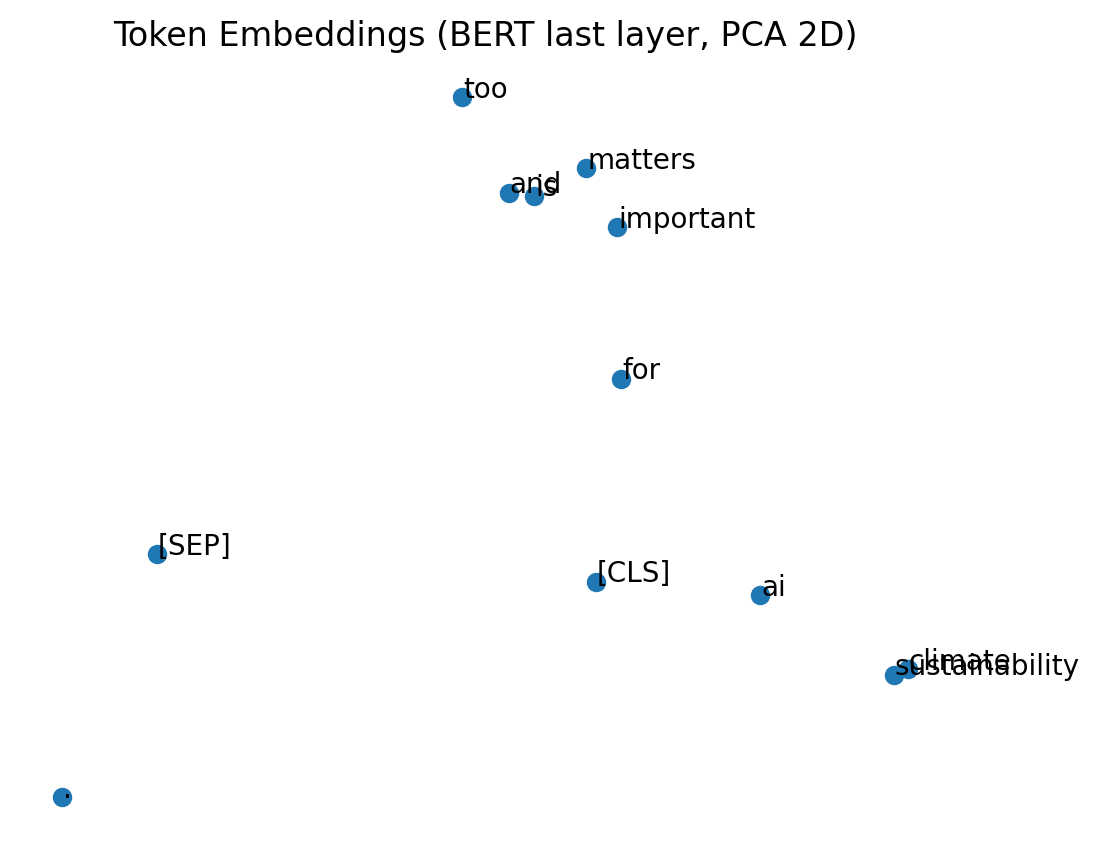

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

emb2d = PCA(n_components=2).fit_transform(embeds.cpu().numpy())
plt.figure(figsize=(6,5))
plt.scatter(emb2d[:,0], emb2d[:,1])
for (x,y,t) in zip(emb2d[:,0], emb2d[:,1], tokens):
    plt.text(x+0.02, y, t)
plt.title("Token Embeddings (BERT last layer, PCA 2D)")
plt.axis('off')
plt.show()
